In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras 
from keras.models import Sequential, Model
from keras.layers import Input, Dense, MultiHeadAttention, Dropout, LayerNormalization
from keras.optimizers import Adam

from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import matplotlib.dates as mdates
from keras.utils import plot_model

In [2]:
# Load dataset
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data/time_series_data.csv', index_col='time_slot', parse_dates=['time_slot'])
df.head()

,n_visits,n_shifts,utilization
time_slot,,,
2019-01-14,14,36,0.600023
2019-01-15,24,36,0.651213
2019-01-16,24,36,0.665499
2019-01-30,23,36,0.661332
2019-01-31,22,37,0.680456


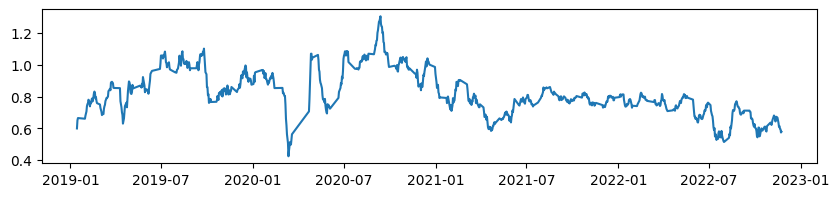

In [3]:
# Initail plot of data and the feature we want to predict - Utilization
x = df.index
y = df['utilization']
plt.figure(figsize=(10, 2))
plt.plot(x,y)

# Data Preprocessing


In [4]:
data = df
scaler = MinMaxScaler() # Scaling data to prepare for algorithm
data_scaled = scaler.fit_transform(data)

look_back=1 # Variable for 'window' used for prediction

# Define function to create time series dataset with features
# Separating predictive feature from input
def create_dataset(data, look_back):
    X, Y = [], []
    for i in range(len(data)-look_back):
        X.append(data[i:(i+look_back)])
        Y.append(data[i+look_back, -1]) # Utilization feature is the last column. Makes it the Y variable
    return np.array(X), np.array(Y)

# Split the dataset
train_size = int(len(data_scaled) * 0.80)
test_size = len(data_scaled) - train_size
train, test = data_scaled[0:train_size], data_scaled[train_size:]
train_X, train_Y = create_dataset(train, look_back)
test_X, test_Y = create_dataset(test, look_back)

# Reshape input to be in the format [samples, time steps, features]
train_X = np.reshape(train_X, (train_X.shape[0], look_back, train_X.shape[2]))
test_X = np.reshape(test_X, (test_X.shape[0], look_back, test_X.shape[2]))

# Check shape of data
print('train_X: ', train_X.shape)
print('test_X: ', test_X.shape)
print('-------')
print('train_Y: ', train_Y.shape)
print('test_Y: ', test_Y.shape)

train_X:  (735, 1, 3)
test_X:  (183, 1, 3)
-------
train_Y:  (735,)
test_Y:  (183,)


# Transformer Models

## Simple Model
With a single MultiHeadAttention layer to check the baseline performance of a simple transformer architecture.

In [30]:
# Define the Transformer Architecture
def transformer_model_1(input_shape):
    inputs = Input(shape=input_shape)
    
    # Attention mechanism
    attn_output = MultiHeadAttention(num_heads=8, key_dim=input_shape[1])(inputs, inputs)
    attn_output = Dropout(0.1)(attn_output)
    out1 = LayerNormalization(epsilon=1e-6)(inputs + attn_output)

    # Fully connected layers
    ffn_output = Dense(input_shape[1], activation='relu')(out1)
    ffn_output = Dense(input_shape[1])(ffn_output)
    ffn_output = Dropout(0.1)(ffn_output)
    out2 = LayerNormalization(epsilon=1e-6)(out1 + ffn_output)

    outputs = Dense(1)(out2)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(lr=0.001), loss='mean_squared_error')
    return model

In [31]:
model1 = transformer_model_1((look_back, train_X.shape[2]))
model1.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 1, 3)]       0           []                               
                                                                                                  
 multi_head_attention_6 (MultiH  (None, 1, 3)        363         ['input_7[0][0]',                
 eadAttention)                                                    'input_7[0][0]']                
                                                                                                  
 dropout_12 (Dropout)           (None, 1, 3)         0           ['multi_head_attention_6[0][0]'] 
                                                                                                  
 tf.__operators__.add_17 (TFOpL  (None, 1, 3)        0           ['input_7[0][0]',          

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


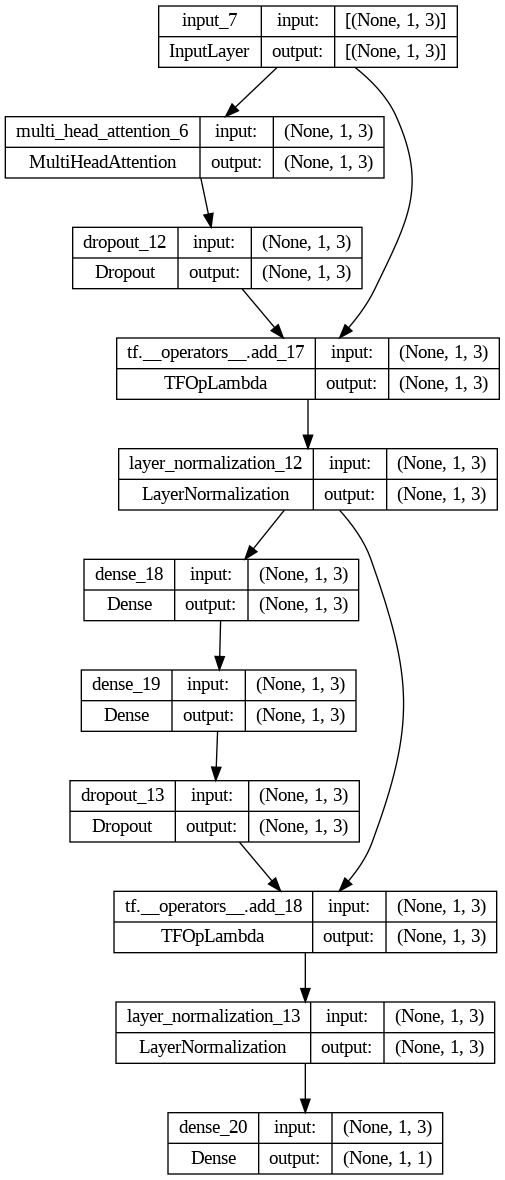

In [38]:
#Print Architecture
plot_model(model1, to_file='transformer_model_1.png', show_shapes=True, show_layer_names=True)

In [33]:
# Fit model to data
history1 = model1.fit(train_X, train_Y, epochs=25, batch_size=1, verbose=2, validation_data=(test_X, test_Y))

# Make predictions
train_pred = model1.predict(train_X)
test_pred = model1.predict(test_X)

# Invert predictions to original scale in order to plot results
train_pred_inv = scaler.inverse_transform(np.hstack((train_X.reshape(-1, 3)[:, :-1], train_pred.reshape(-1, 1))))
test_pred_inv = scaler.inverse_transform(np.hstack((test_X.reshape(-1, 3)[:, :-1], test_pred.reshape(-1, 1))))
train_Y_inv = scaler.inverse_transform(np.hstack((train_X.reshape(-1, 3)[:, :-1], train_Y.reshape(-1, 1))))
test_Y_inv = scaler.inverse_transform(np.hstack((test_X.reshape(-1, 3)[:, :-1], test_Y.reshape(-1, 1))))

# Calculate root mean squared error
train_score = np.sqrt(mean_squared_error(train_Y_inv[:, -1], train_pred_inv[:, -1]))
test_score = np.sqrt(mean_squared_error(test_Y_inv[:, -1], test_pred_inv[:, -1]))
print('------ Train Score: {:.2f} RMSE ------'.format(train_score))
print('------ Test Score: {:.2f} RMSE ------'.format(test_score))

Epoch 1/25
735/735 - 2s - loss: 0.0261 - val_loss: 0.0511 - 2s/epoch - 2ms/step
Epoch 2/25
735/735 - 2s - loss: 0.0237 - val_loss: 0.0538 - 2s/epoch - 3ms/step
Epoch 3/25
735/735 - 2s - loss: 0.0234 - val_loss: 0.0463 - 2s/epoch - 3ms/step
Epoch 4/25
735/735 - 2s - loss: 0.0229 - val_loss: 0.0426 - 2s/epoch - 2ms/step
Epoch 5/25
735/735 - 2s - loss: 0.0232 - val_loss: 0.0557 - 2s/epoch - 2ms/step
Epoch 6/25
735/735 - 2s - loss: 0.0219 - val_loss: 0.0354 - 2s/epoch - 2ms/step
Epoch 7/25
735/735 - 1s - loss: 0.0145 - val_loss: 0.0037 - 1s/epoch - 2ms/step
Epoch 8/25
735/735 - 2s - loss: 0.0121 - val_loss: 0.0105 - 2s/epoch - 2ms/step
Epoch 9/25
735/735 - 2s - loss: 0.0089 - val_loss: 7.5096e-04 - 2s/epoch - 2ms/step
Epoch 10/25
735/735 - 2s - loss: 0.0064 - val_loss: 7.1459e-04 - 2s/epoch - 3ms/step
Epoch 11/25
735/735 - 2s - loss: 0.0074 - val_loss: 0.0025 - 2s/epoch - 3ms/step
Epoch 12/25
735/735 - 1s - loss: 0.0052 - val_loss: 0.0045 - 1s/epoch - 2ms/step
Epoch 13/25
735/735 - 1s - lo

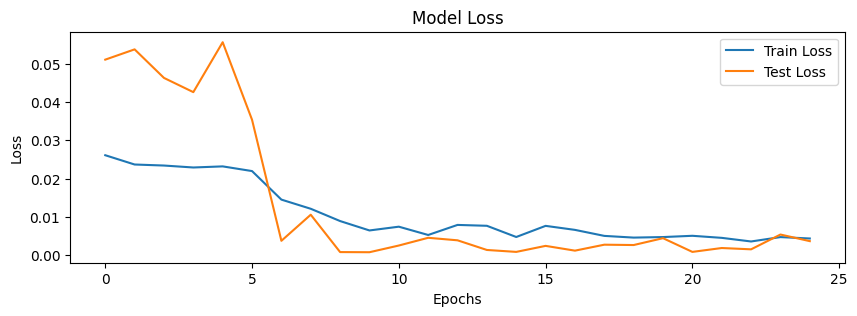

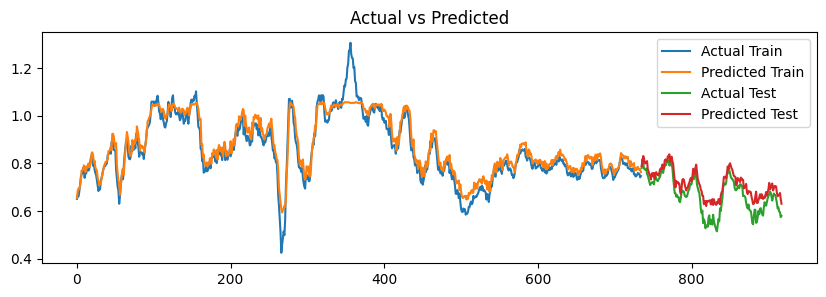

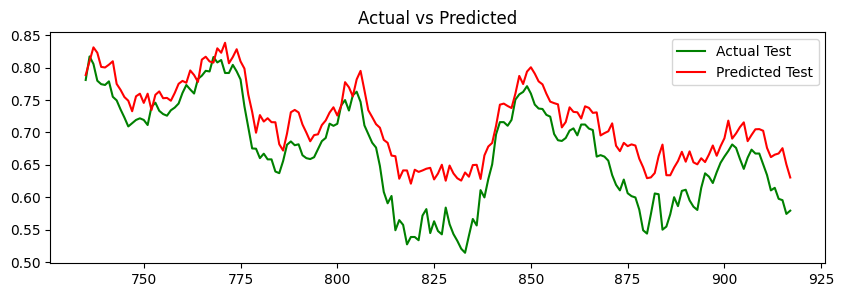

In [35]:
# Plotting training loss
plt.figure(figsize=(10,3))
plt.plot(history1.history['loss'], label='Train Loss')
plt.plot(history1.history['val_loss'], label='Test Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting actual vs predicted data
plt.figure(figsize=(10,3))
# Training data
plt.plot(train_Y_inv[:, -1], label='Actual Train')
plt.plot(train_pred_inv[:, -1], label='Predicted Train')

# Test data
plt.plot(np.arange(len(train_Y_inv), len(train_Y_inv) + len(test_Y_inv)), test_Y_inv[:, -1], label='Actual Test')
plt.plot(np.arange(len(train_pred_inv), len(train_pred_inv) + len(test_pred_inv)), test_pred_inv[:, -1], label='Predicted Test')
plt.legend()
plt.title("Actual vs Predicted")
plt.show()

# Plotting actual vs predicted data
plt.figure(figsize=(10,3))
# Test data
plt.plot(np.arange(len(train_Y_inv), len(train_Y_inv) + len(test_Y_inv)), test_Y_inv[:, -1], label='Actual Test', c='g')
plt.plot(np.arange(len(train_pred_inv), len(train_pred_inv) + len(test_pred_inv)), test_pred_inv[:, -1], label='Predicted Test', c='r')

plt.legend()
plt.title("Actual vs Predicted")
plt.show()

### Model Comments
Sufficient results from a very basic transformer-based model. Impressive ability to fit the test data given the simplicity.

Furhter discussion found in report.

## Complex with similar charactaristics to original Transformer

In [5]:
def transformer_model_2(input_shape):
    num_heads = 8  # Number of attention heads
    ff_dim = 32  # Hidden layer size in feed forward network inside transformer

    # Inputs - one for ecoder block and one for decoder block
    # in order to have the encoder-decoder attention mechanism
    encoder_inputs = Input(shape=input_shape)
    decoder_inputs = Input(shape=input_shape)

    # Encoder layers - self-attention followed by a feed forward NN
    encoder_att = MultiHeadAttention(num_heads=num_heads, key_dim=input_shape[-1])(encoder_inputs, encoder_inputs)
    encoder_att = Dropout(0.1)(encoder_att)
    encoder_out = LayerNormalization(epsilon=1e-6)(encoder_inputs + encoder_att)

    encoder_ffn = Dense(ff_dim, activation='relu')(encoder_out)
    encoder_ffn = Dense(input_shape[-1])(encoder_ffn)
    encoder_ffn = Dropout(0.1)(encoder_ffn)
    encoder_out = LayerNormalization(epsilon=1e-6)(encoder_out + encoder_ffn)

    # Decoder layers with encoder-decoder attention + feed forward NN
    decoder_att1 = MultiHeadAttention(num_heads=num_heads, key_dim=input_shape[-1])(decoder_inputs, decoder_inputs)
    decoder_att1 = Dropout(0.1)(decoder_att1)
    decoder_out = LayerNormalization(epsilon=1e-6)(decoder_inputs + decoder_att1)

    decoder_att2 = MultiHeadAttention(num_heads=num_heads, key_dim=input_shape[-1])(decoder_out, encoder_out)
    decoder_att2 = Dropout(0.1)(decoder_att2)
    decoder_out = LayerNormalization(epsilon=1e-6)(decoder_out + decoder_att2)

    decoder_ffn = Dense(ff_dim, activation='relu')(decoder_out)
    decoder_ffn = Dense(input_shape[-1])(decoder_ffn)
    decoder_ffn = Dropout(0.1)(decoder_ffn)
    decoder_out = LayerNormalization(epsilon=1e-6)(decoder_out + decoder_ffn)

    # Final output
    outputs = Dense(1)(decoder_out)

    model = Model(inputs=[encoder_inputs, decoder_inputs], outputs=outputs)
    model.compile(optimizer=Adam(lr=0.001), loss='mean_squared_error')
    return model


In [6]:
model2 = transformer_model_2((look_back, train_X.shape[2]))
model2.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1, 3)]       0           []                               
                                                                                                  
 multi_head_attention (MultiHea  (None, 1, 3)        363         ['input_1[0][0]',                
 dAttention)                                                      'input_1[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 1, 3)         0           ['multi_head_attention[0][0]']   
                                                                                                  
 tf.__operators__.add (TFOpLamb  (None, 1, 3)        0           ['input_1[0][0]',            

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


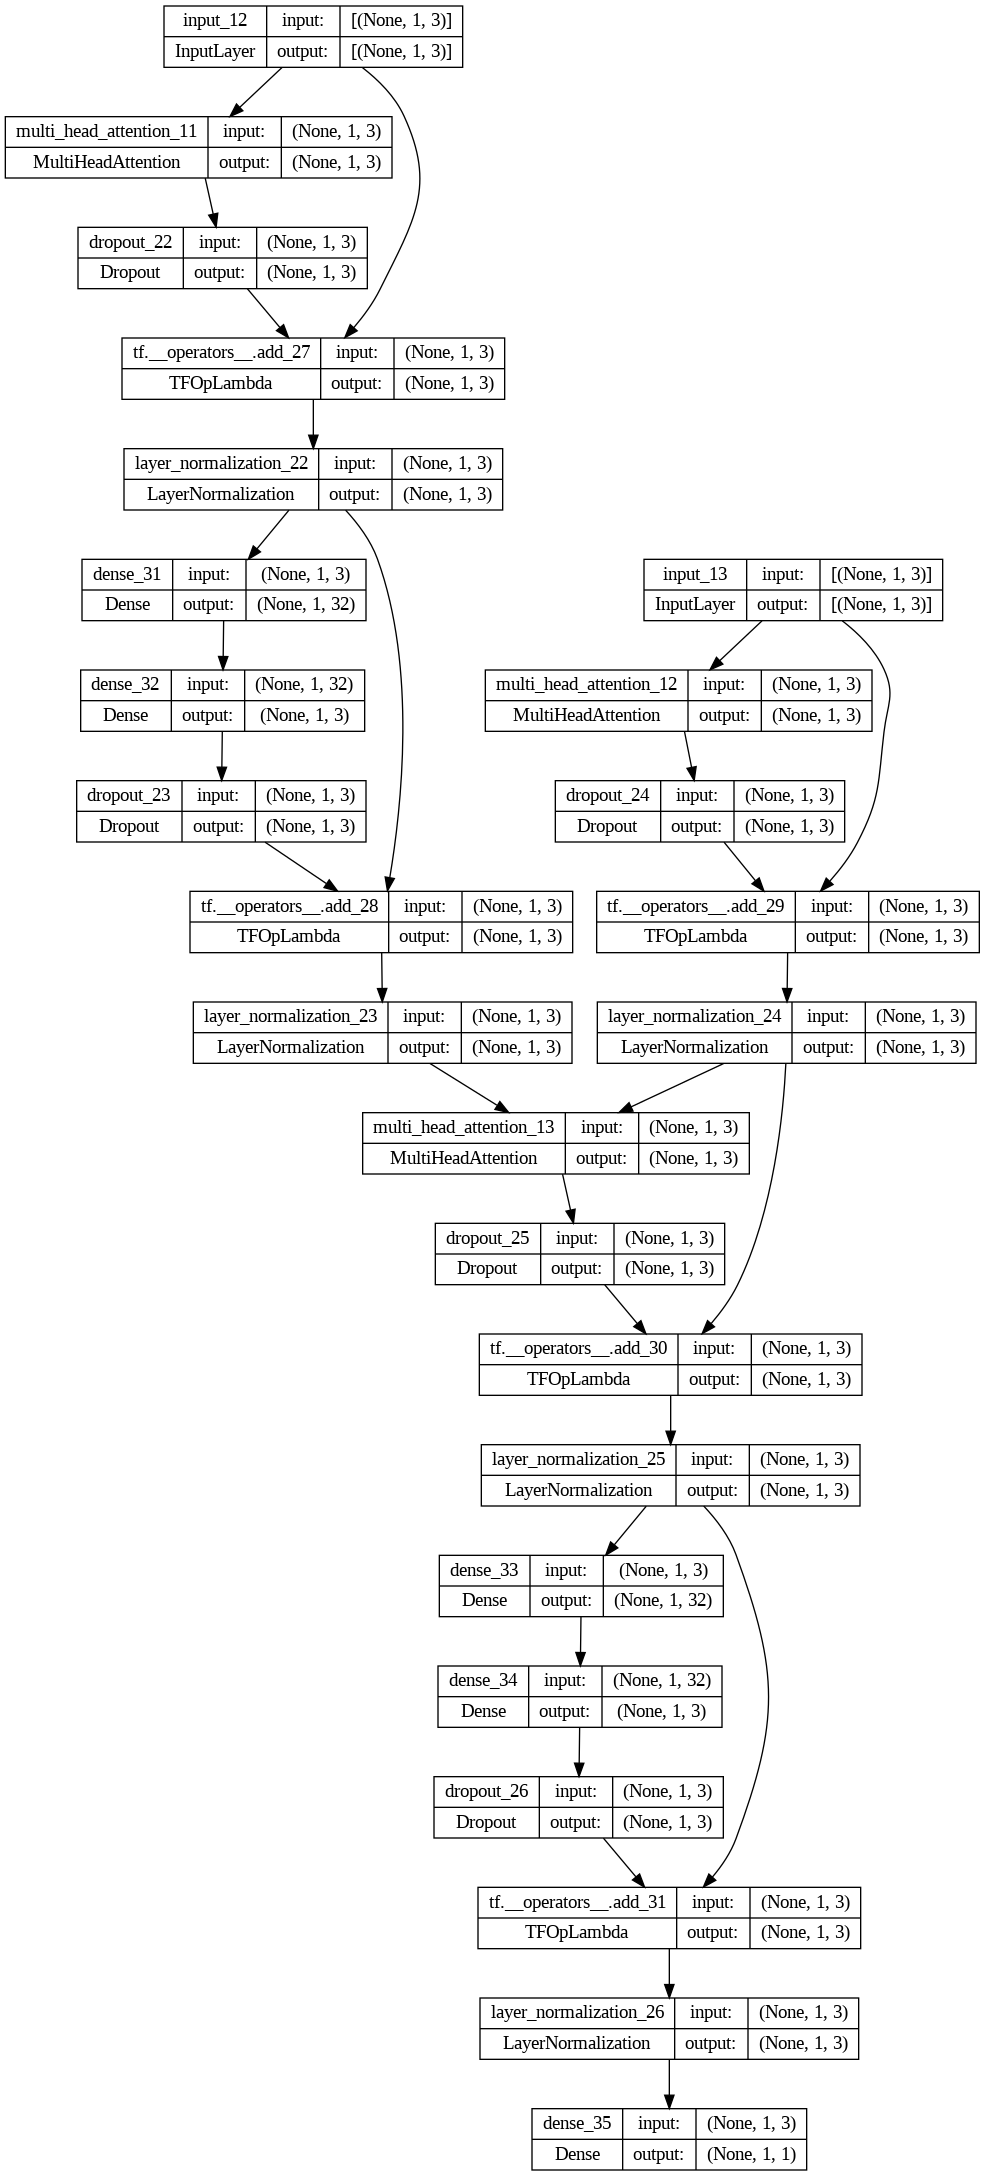

In [53]:
#Print Architecture
plot_model(model2, to_file='transformer_model_2.png', show_shapes=True, show_layer_names=True)

In [7]:
# Complex
history2 = model2.fit([train_X, train_X], train_Y, validation_data=([test_X, test_X], test_Y), epochs=50, batch_size=1, verbose=1)

# Make predictions
train_pred = model2.predict([train_X, train_X])
test_pred = model2.predict([test_X, test_X])

# Invert predictions
train_pred_inv = scaler.inverse_transform(np.hstack((train_X.reshape(-1, train_X.shape[-1])[:, :-1], train_pred.reshape(-1, 1))))
test_pred_inv = scaler.inverse_transform(np.hstack((test_X.reshape(-1, test_X.shape[-1])[:, :-1], test_pred.reshape(-1, 1))))
train_Y_inv = scaler.inverse_transform(np.hstack((train_X.reshape(-1, train_X.shape[-1])[:, :-1], train_Y.reshape(-1, 1))))
test_Y_inv = scaler.inverse_transform(np.hstack((test_X.reshape(-1, test_X.shape[-1])[:, :-1], test_Y.reshape(-1, 1))))

# Calculate root mean squared error
train_score = np.sqrt(mean_squared_error(train_Y_inv[:, -1], train_pred_inv[:, -1]))
test_score = np.sqrt(mean_squared_error(test_Y_inv[:, -1], test_pred_inv[:, -1]))
print('------ Train Score: {:.2f} RMSE ------'.format(train_score))
print('------ Test Score: {:.2f} RMSE ------'.format(test_score))

Epoch 1/50
735/735 [==============================] - 10s 6ms/step - loss: 0.0404 - val_loss: 0.0318
Epoch 2/50
735/735 [==============================] - 4s 6ms/step - loss: 0.0167 - val_loss: 0.0248
Epoch 3/50
735/735 [==============================] - 5s 7ms/step - loss: 0.0155 - val_loss: 0.0395
Epoch 4/50
735/735 [==============================] - 4s 6ms/step - loss: 0.0138 - val_loss: 0.0171
Epoch 5/50
735/735 [==============================] - 4s 6ms/step - loss: 0.0133 - val_loss: 0.0045
Epoch 6/50
735/735 [==============================] - 5s 7ms/step - loss: 0.0096 - val_loss: 0.0037
Epoch 7/50
735/735 [==============================] - 4s 6ms/step - loss: 0.0066 - val_loss: 0.0055
Epoch 8/50
735/735 [==============================] - 4s 6ms/step - loss: 0.0119 - val_loss: 0.0134
Epoch 9/50
735/735 [==============================] - 5s 7ms/step - loss: 0.0075 - val_loss: 0.0087
Epoch 10/50
735/735 [==============================] - 4s 6ms/step - loss: 0.0060 - val_loss: 0.003

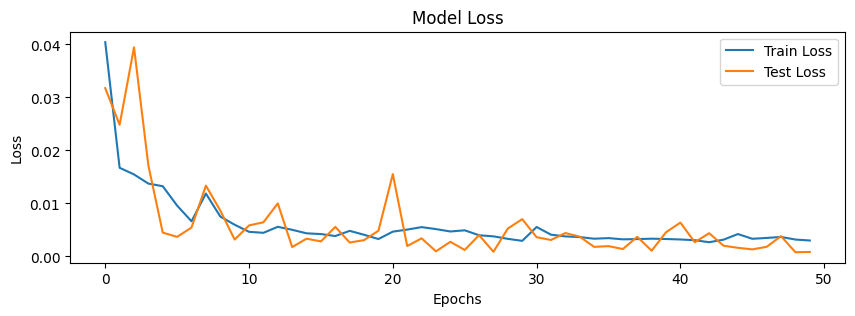

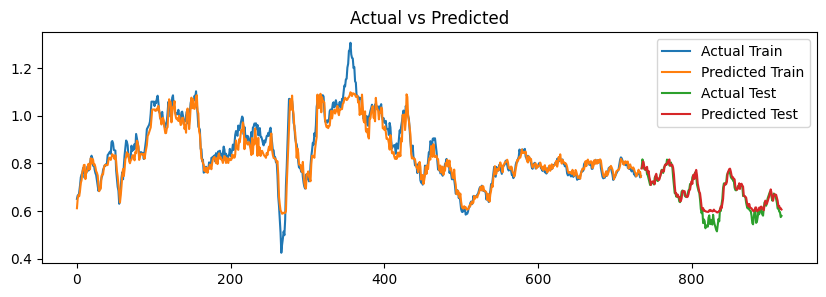

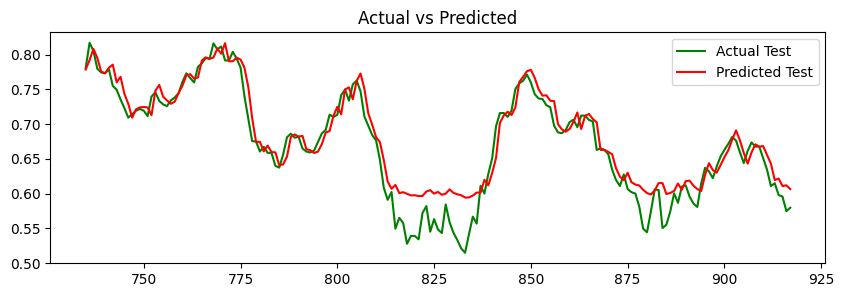

In [8]:
# Plotting training loss
plt.figure(figsize=(10,3))
plt.plot(history2.history['loss'], label='Train Loss')
plt.plot(history2.history['val_loss'], label='Test Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting actual vs predicted data
plt.figure(figsize=(10,3))
# Training data
plt.plot(train_Y_inv[:, -1], label='Actual Train')
plt.plot(train_pred_inv[:, -1], label='Predicted Train')

# Test data
plt.plot(np.arange(len(train_Y_inv), len(train_Y_inv) + len(test_Y_inv)), test_Y_inv[:, -1], label='Actual Test')
plt.plot(np.arange(len(train_pred_inv), len(train_pred_inv) + len(test_pred_inv)), test_pred_inv[:, -1], label='Predicted Test')
plt.legend()
plt.title("Actual vs Predicted")
plt.show()

# Plotting actual vs predicted data
plt.figure(figsize=(10,3))
# Test data
plt.plot(np.arange(len(train_Y_inv), len(train_Y_inv) + len(test_Y_inv)), test_Y_inv[:, -1], label='Actual Test', c='g')
plt.plot(np.arange(len(train_pred_inv), len(train_pred_inv) + len(test_pred_inv)), test_pred_inv[:, -1], label='Predicted Test', c='r')

plt.legend()
plt.title("Actual vs Predicted")
plt.show()

### Model Comments
Highly impressive results and very good ability to fit the test data. Proves that more complex transformer models are higly applicable to time-series.

Furhter discussion found in report.

# Larger Look back Variable

This code block applies the complex architecture but with a larger look_back variable which increases the window size of the model.

In [73]:
data = df
target_scaler = MinMaxScaler()
target = data['utilization'].values.reshape(-1, 1)  # Replace 'target' with your actual target column name
target_scaled = target_scaler.fit_transform(target)

# Replace the target column in your data_scaled array with the newly scaled target
data_scaled[:,-1] = target_scaled.ravel()

look_back=30 # Variable for 'window' used for prediction

# Define function to create time series dataset with additional features
def create_dataset(data, look_back):
    X, Y = [], []
    for i in range(len(data)-look_back-1):
        X.append(data[i:(i+look_back), :])
        Y.append(data[i+look_back, -1]) # Utilization is the last column
    return np.array(X), np.array(Y)

# Split the dataset
train_size = int(len(data_scaled) * 0.80)
test_size = len(data_scaled) - train_size
train, test = data_scaled[0:train_size], data_scaled[train_size:]
train_X, train_Y = create_dataset(train, look_back)
test_X, test_Y = create_dataset(test, look_back)

# Reshape Y to have an extra dimension
train_Y = np.expand_dims(train_Y, axis=1)
test_Y = np.expand_dims(test_Y, axis=1)

# Reshape input to be in the format [samples, time steps, features]
train_X = np.reshape(train_X, (train_X.shape[0], look_back, train_X.shape[2]))
test_X = np.reshape(test_X, (test_X.shape[0], look_back, test_X.shape[2]))


def transformer_model_2(input_shape):
    num_heads = 8  # Number of attention heads
    ff_dim = 32  # Hidden layer size in feed forward network inside transformer

    # Inputs
    encoder_inputs = Input(shape=input_shape)
    decoder_inputs = Input(shape=input_shape)

    # Encoder layers
    encoder_att = MultiHeadAttention(num_heads=num_heads, key_dim=input_shape[-1])(encoder_inputs, encoder_inputs)
    encoder_att = Dropout(0.1)(encoder_att)
    encoder_out = LayerNormalization(epsilon=1e-6)(encoder_inputs + encoder_att)

    encoder_ffn = Dense(ff_dim, activation='relu')(encoder_out)
    encoder_ffn = Dense(input_shape[-1])(encoder_ffn)
    encoder_ffn = Dropout(0.1)(encoder_ffn)
    encoder_out = LayerNormalization(epsilon=1e-6)(encoder_out + encoder_ffn)

    # Decoder layers with encoder-decoder attention
    decoder_att1 = MultiHeadAttention(num_heads=num_heads, key_dim=input_shape[-1])(decoder_inputs, decoder_inputs)
    decoder_att1 = Dropout(0.1)(decoder_att1)
    decoder_out = LayerNormalization(epsilon=1e-6)(decoder_inputs + decoder_att1)

    decoder_att2 = MultiHeadAttention(num_heads=num_heads, key_dim=input_shape[-1])(decoder_out, encoder_out)
    decoder_att2 = Dropout(0.1)(decoder_att2)
    decoder_out = LayerNormalization(epsilon=1e-6)(decoder_out + decoder_att2)

    decoder_ffn = Dense(ff_dim, activation='relu')(decoder_out)
    decoder_ffn = Dense(input_shape[-1])(decoder_ffn)
    decoder_ffn = Dropout(0.1)(decoder_ffn)
    decoder_out = LayerNormalization(epsilon=1e-6)(decoder_out + decoder_ffn)

    # Final output
    outputs = Dense(1)(decoder_out)

    model = Model(inputs=[encoder_inputs, decoder_inputs], outputs=outputs)
    model.compile(optimizer=Adam(lr=0.001), loss='mean_squared_error')
    return model

model3 = transformer_model_2((look_back, train_X.shape[2]))
history3 = model3.fit([train_X, train_X], train_Y, validation_data=([test_X, test_X], test_Y), epochs=40, batch_size=1, verbose=1)

# Make predictions
train_pred = model3.predict([train_X, train_X])
test_pred = model3.predict([test_X, test_X])

# Squeeze the predictions to remove extra dimension
train_pred = np.squeeze(train_pred, axis=-1)
test_pred = np.squeeze(test_pred, axis=-1)

# Invert predictions
train_pred_inv = target_scaler.inverse_transform(train_pred)
test_pred_inv = target_scaler.inverse_transform(test_pred)
train_Y_inv = target_scaler.inverse_transform(train_Y)
test_Y_inv = target_scaler.inverse_transform(test_Y)



# Calculate root mean squared error
train_score = np.sqrt(mean_squared_error(train_Y_inv[:, -1], train_pred_inv[:, -1]))
test_score = np.sqrt(mean_squared_error(test_Y_inv[:, -1], test_pred_inv[:, -1]))
print('------ Train Score: {:.2f} RMSE ------'.format(train_score))
print('------ Test Score: {:.2f} RMSE ------'.format(test_score))



Epoch 1/40


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


705/705 [==============================] - 10s 9ms/step - loss: 0.0734 - val_loss: 0.0181
Epoch 2/40
705/705 [==============================] - 5s 7ms/step - loss: 0.0196 - val_loss: 0.0280
Epoch 3/40
705/705 [==============================] - 5s 7ms/step - loss: 0.0159 - val_loss: 0.0166
Epoch 4/40
705/705 [==============================] - 6s 9ms/step - loss: 0.0146 - val_loss: 0.0175
Epoch 5/40
705/705 [==============================] - 6s 9ms/step - loss: 0.0132 - val_loss: 0.0081
Epoch 6/40
705/705 [==============================] - 6s 8ms/step - loss: 0.0135 - val_loss: 0.0205
Epoch 7/40
705/705 [==============================] - 5s 8ms/step - loss: 0.0125 - val_loss: 0.0179
Epoch 8/40
705/705 [==============================] - 4s 6ms/step - loss: 0.0121 - val_loss: 0.0163
Epoch 9/40
705/705 [==============================] - 6s 9ms/step - loss: 0.0116 - val_loss: 0.0102
Epoch 10/40
705/705 [==============================] - 6s 9ms/step - loss: 0.0118 - val_loss: 0.0143
Epoch 11/

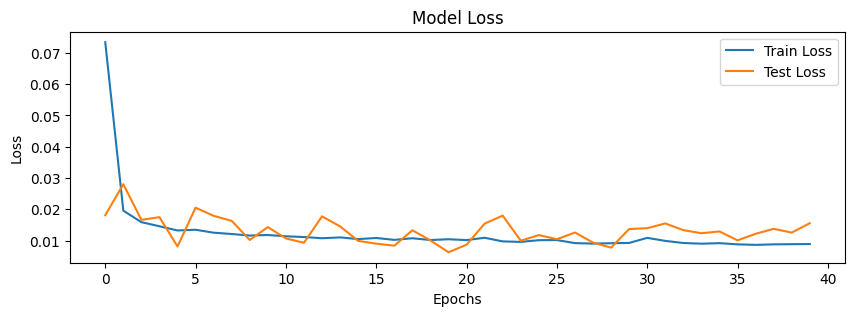

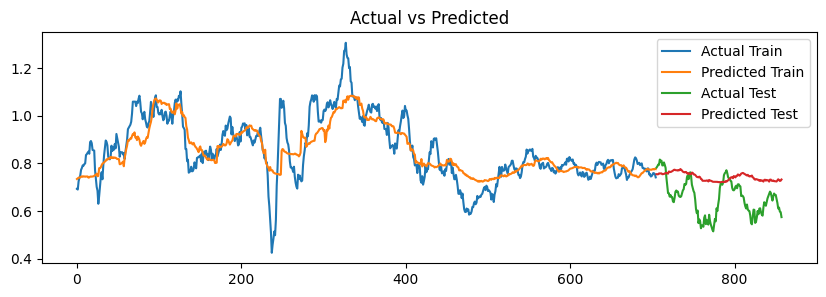

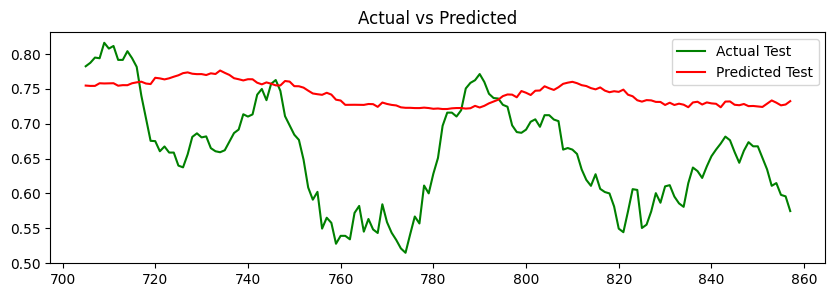

In [74]:
# Plotting training loss
plt.figure(figsize=(10,3))
plt.plot(history3.history['loss'], label='Train Loss')
plt.plot(history3.history['val_loss'], label='Test Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting actual vs predicted data
plt.figure(figsize=(10,3))
# Training data
plt.plot(train_Y_inv[:, -1], label='Actual Train')
plt.plot(train_pred_inv[:, -1], label='Predicted Train')

# Test data
plt.plot(np.arange(len(train_Y_inv), len(train_Y_inv) + len(test_Y_inv)), test_Y_inv[:, -1], label='Actual Test')
plt.plot(np.arange(len(train_pred_inv), len(train_pred_inv) + len(test_pred_inv)), test_pred_inv[:, -1], label='Predicted Test')
plt.legend()
plt.title("Actual vs Predicted")
plt.show()

# Plotting actual vs predicted data
plt.figure(figsize=(10,3))
# Test data
plt.plot(np.arange(len(train_Y_inv), len(train_Y_inv) + len(test_Y_inv)), test_Y_inv[:, -1], label='Actual Test', c='g')
plt.plot(np.arange(len(train_pred_inv), len(train_pred_inv) + len(test_pred_inv)), test_pred_inv[:, -1], label='Predicted Test', c='r')

plt.legend()
plt.title("Actual vs Predicted")
plt.show()

### Comments
Not very impressive results. Seems like the larger window applies a smoothing effect to the model, making it less efficient at comprehending details in the data.

Furhter discussion found in report.